This notebook aims to implement methods (padding, windowing) to reduce artefacts in Fourier transforms of memory signals. It also explores the effects of these methods on the resulting frequency spectra. 

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import importlib
import utils_signal as usig


In [22]:
# Test the functions with a sample waveform
mtot = 100  # Total mass in solar masses
m1 = m2 = mtot/2
dt = 1.0/4096
distance = 100

time_raw, raw_signal,hc = usig.get_hp_hc_waveform(approximant='SEOBNRv4_opt',
                                                  mass1=m1,
                                                  mass2=m2,
                                                  distance=distance,
                                                  delta_t=dt,
                                                  f_lower=20.0,
                                                  inclination=np.pi/2)
fs = int(1.0 / dt)


aligned_time, aligned_signal = usig.align_signal(raw_signal, time_raw)

windowed_signal = usig.apply_window(aligned_signal, window_type='tukey', alpha=0.2)

padded_time, padded_signal = usig.pad_signal(windowed_signal,aligned_time, r = 0.5)

filtered_signal = usig.bandpass_filter(padded_signal, fs, lowcut=10, highcut=1000)

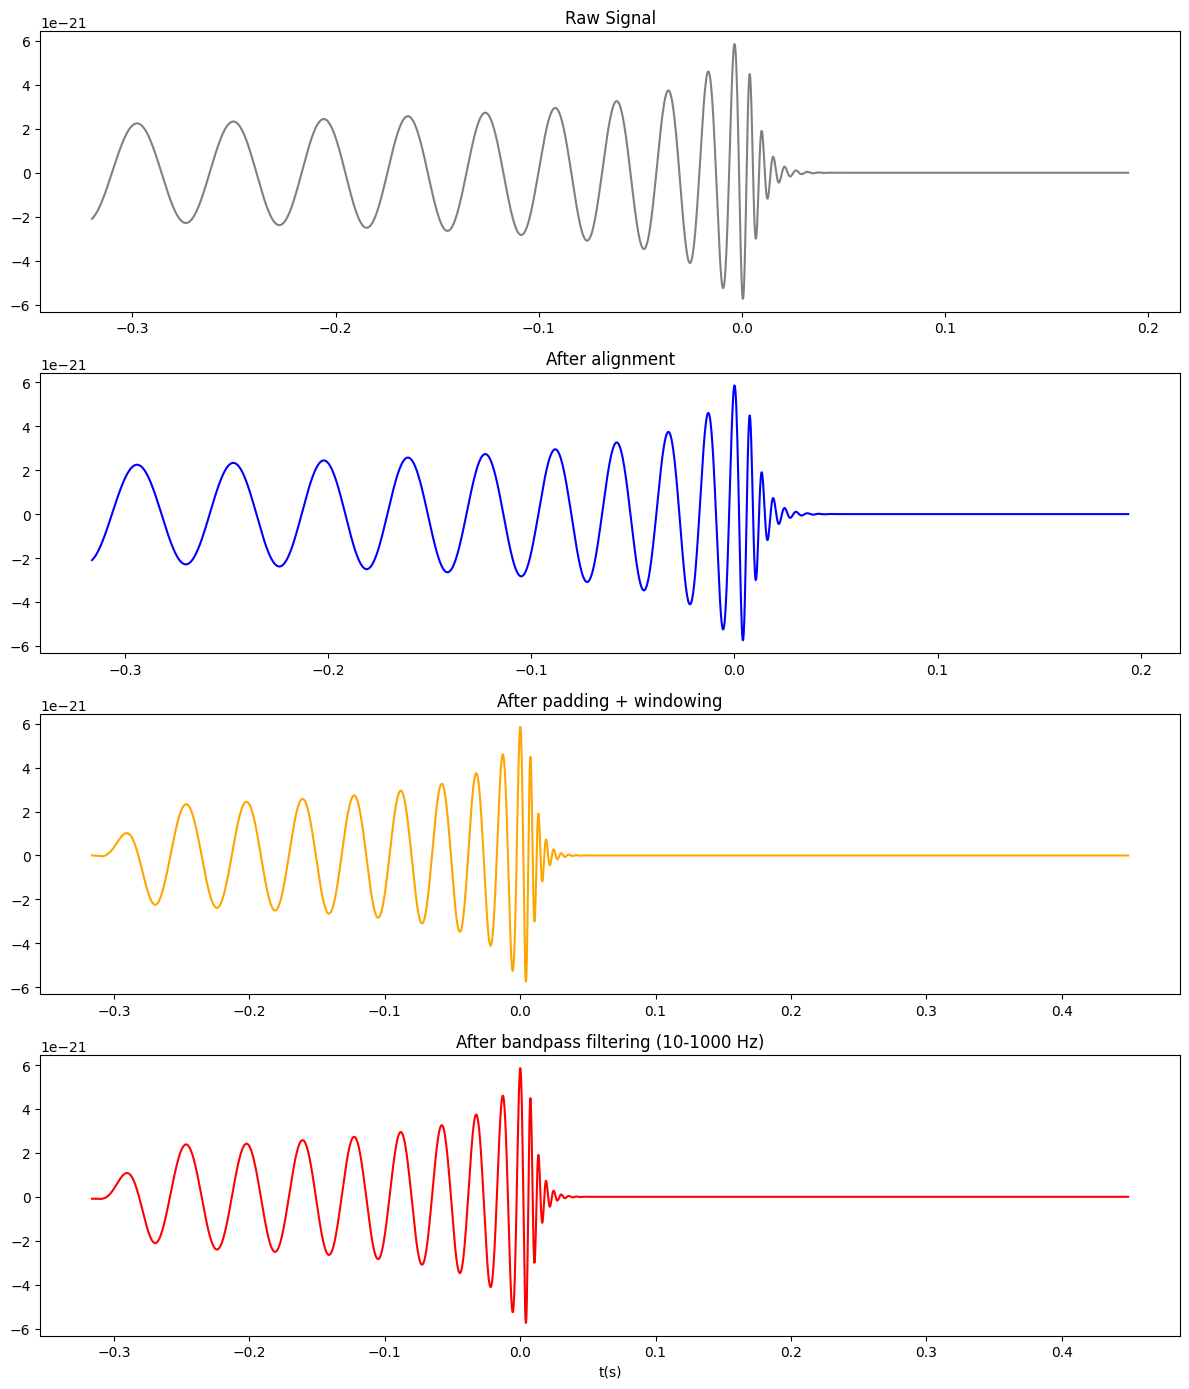

In [23]:
fig, axs = plt.subplots(4, 1, figsize=(12, 14))
axs[0].plot(time_raw, raw_signal, color='gray')
axs[0].set_title("Raw Signal")

axs[1].plot(aligned_time, aligned_signal, color='blue')
axs[1].set_title("After alignment")

axs[2].plot(padded_time, padded_signal, color='orange')
axs[2].set_title("After padding + windowing")

axs[3].plot(padded_time, filtered_signal, color='red')
axs[3].set_title("After bandpass filtering (10-1000 Hz)")

plt.xlabel('t(s)')
plt.tight_layout()
plt.show()

Now we can compute the memory signal and compare it with the raw signal in the frequency domain

/usr/local/lib64/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib64/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


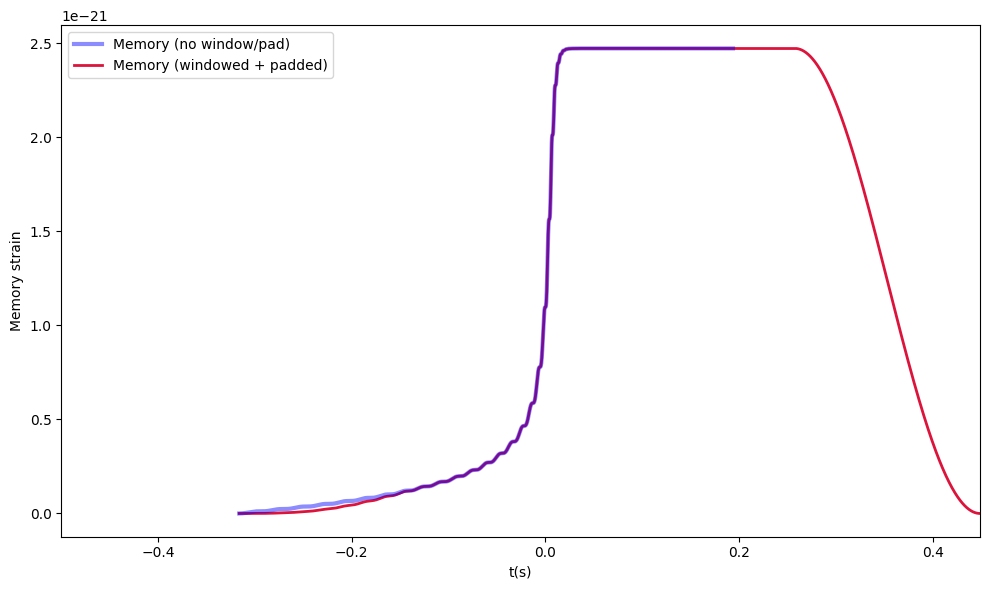

In [24]:
mtot = 100  # Total mass in solar masses
m1 = m2 = mtot/2
dt = 1.0/4096
distance = 100

time_raw, raw_signal,hc = usig.get_hp_hc_waveform(approximant='SEOBNRv4_opt',
                                                  mass1=m1,
                                                  mass2=m2,
                                                  distance=distance,
                                                  delta_t=dt,
                                                  f_lower=20.0,
                                                  inclination=np.pi/2)
fs = int(1.0 / dt)
r = 0.5  # padding ratio

# Align and pad the signal
aligned_time, aligned_signal = usig.align_signal(raw_signal, time_raw)
padded_time, padded_signal = usig.pad_signal(aligned_signal,aligned_time, r)

# Compute memory for aligned signal and padded signal with memory windowing
hmem_centered = usig.compute_memory(aligned_signal, distance, dt)

hmem_winpad = usig.compute_memory(padded_signal , distance, dt)
hmem_winpad = usig.apply_window(hmem_winpad, window_type='tukey', alpha=0.5)



plt.figure(figsize=(10,6))
plt.plot(aligned_time, hmem_centered, label='Memory (no window/pad)', color='blue', lw = 3, zorder = 5, alpha=0.45)
plt.plot(padded_time, hmem_winpad, label='Memory (windowed + padded)', color='crimson', lw=2)
plt.xlabel('t(s)')
plt.ylabel('Memory strain')
plt.xlim(-0.5,np.max(padded_time))
plt.legend()
plt.tight_layout()
plt.show()

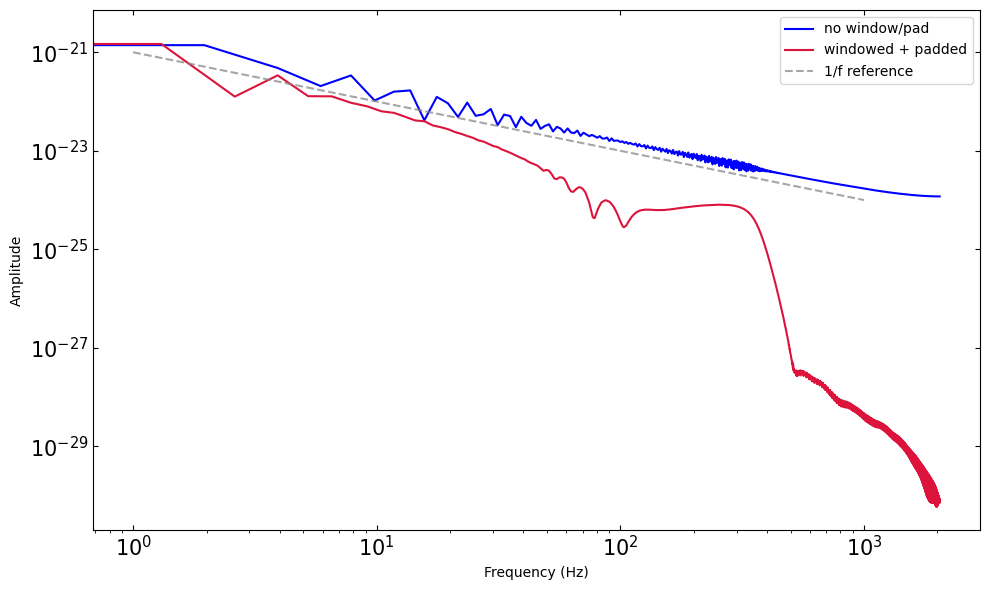

In [25]:
# FFT of the memory
freq_centered, fft_centered = usig.fft_signal(aligned_time, hmem_centered)
freq_winpad, fft_winpad = usig.fft_signal(padded_time, hmem_winpad)
# Also plot 1/f line for reference
f = np.logspace(0, 3, 100)
one_over_f = 1 / f

plt.figure(figsize=(10,6))
plt.plot(freq_centered, fft_centered, label='no window/pad', color='blue')
plt.plot(freq_winpad, fft_winpad, label='windowed + padded', color='crimson')
plt.plot(f, one_over_f*1e-21, label='1/f reference', color='grey', linestyle='--', alpha=0.7)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.tick_params(top=True, right=True, axis='both', which='major', labelsize=15, direction='in')
plt.legend()
plt.tight_layout()
plt.show()